In [1]:
library(dplyr)
library(lattice)
library(reshape2)
library(Hmisc)
library(gplots)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: grid
Loading required package: survival
Loading required package: Formula
Loading required package: ggplot2

Attaching package: ‘Hmisc’

The following objects are masked from ‘package:dplyr’:

    combine, src, summarize

The following objects are masked from ‘package:base’:

    format.pval, round.POSIXt, trunc.POSIXt, units


Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess



In [2]:
# Read CSV ----------------------------------------------------------------
airfare <- read.csv("~/notebooks/AirFare/Data/tripRequest.csv", header=TRUE, dec=".", sep=";")

In [3]:
# [DataFrame] Drop double&uncess informtion --------------------------------------
airfare <- subset(airfareCSV, select = -c(requestString,tripRequest_id,requestDate,tripReturn,sliceDuration,tripStart,tripDestination))
airfare <- subset(airfare, select = -c(trip_id.1,trip_id.2,trip_id.3))
airfare <- subset(airfare, select = -c(tripOrder.1,tripOrder.2))
airfare <- subset(airfare, select = -c(tripRequest_id.1))

# Data Formats ------------------------------------------------------------
airfare$package <- as.POSIXct(strptime(airfare$package, "%d-%m-%Y"))
airfare$tripStartDeparture <- as.POSIXct(strptime(airfare$tripStartDeparture, "%Y-%m-%d %H:%M:%S"))
airfare$tripDestinationDeparture <- as.POSIXct(strptime(airfare$tripDestinationDeparture, "%Y-%m-%d %H:%M:%S"))
airfare$arrivalTime <- as.POSIXct(strptime(airfare$arrivalTime, "%Y-%m-%d %H:%M:%S"))
airfare$departureTime <- as.POSIXct(strptime(airfare$departureTime, "%Y-%m-%d %H:%M:%S"))

# Splitting Data into smaller Packages ------------------------------------
#data.fare <- airfare %>% group_by(trip_id) %>% summarise(saleTotal = mean(saleTotal, na.rm=TRUE))
subset.fares <- filter(airfare, marriedSegmentGroup==0) #Only one trip necessary for pricing
subset.fares <- subset.fares %>% select(trip_id,package,tripStartDeparture,flightCarrier,saleTotal,operatingDisclosure)

# add daysBeforeDeparture/BookingDays
subset.fares$package <- as.POSIXct(subset.fares$package, format='%Y/%m/%d')
subset.fares$daysBeforeDeparture <- as.POSIXct(strftime(subset.fares$tripStartDeparture, format="%Y/%m/%d"))

# Difference of request date and actual departure (to see how many days before the flight it was "booked")
subset.fares$daysBeforeDeparture <- as.numeric(round(difftime(subset.fares$daysBeforeDeparture, subset.fares$package, units="days")))

# remove uncessary columns
subset.fares <- subset(subset.fares, select = -c(trip_id, package, tripStartDeparture))

# remove operated by
subset.fares$operatingDisclosure <- gsub("\\b(OPERATED|BY )\\b", "", subset.fares$operatingDisclosure, fixed=FALSE)
subset.fares$operatingDisclosure <- gsub("[[:space:]]", "", subset.fares$operatingDisclosure, fixed=FALSE)
subset.fares$operatingDisclosure <- sub("NULL", NA, subset.fares$operatingDisclosure, fixed=TRUE)

# combine columns and remove
subset.fares$carrier <- gsub(", $", "", paste(subset.fares$flightCarrier, ifelse(is.na(subset.fares$operatingDisclosure), "*", subset.fares$operatingDisclosure) ,sep ="_"))
subset.fares$carrier <- sub("\\_\\*", '', subset.fares$carrier)
subset.fares <- subset(subset.fares, select = -c(flightCarrier, operatingDisclosure))

# output
head(subset.fares,3)

ERROR: Error in subset(airfareCSV, select = -c(requestString, tripRequest_id, : object 'airfareCSV' not found


,saleTotal,daysBeforeDeparture,carrier
1,477.99,0,KL_DELTA
2,477.99,0,AF_DELTA
3,556.31,0,SQ


In [4]:
subset.fares.long <- dcast(subset.fares, daysBeforeDeparture ~ carrier, mean, value.var="saleTotal")
head(subset.fares.long,2)

,daysBeforeDeparture,AF_DELTA,KL_DELTA,LH,LH_UNITED,SQ,UA,UA_LUFTHANSA
1,0,868.9146,895.0565,1045.84,1095.193,632.3809,1060.372,1040.029
2,1,928.7651,936.3686,1068.546,1083.872,632.0733,1054.923,1022.147


In [5]:
#plot(subset.fares.long)
# pearson
fare.correlation <- cor(subset.fares.long)
fare.correlation <- round(fare.correlation,2)
fare.correlation

fare.correlation_kendall <- round(cor(subset.fares.long, method = "kendall"), 2)
fare.correlation_spearman <- round(cor(subset.fares.long, method = "spearman"), 2)

## How much do they differ?
i <- lower.tri(fare.correlation)
cor(cbind(P = fare.correlation[i], S = fare.correlation_spearman[i], K = fare.correlation_kendall[i]))






,daysBeforeDeparture,AF_DELTA,KL_DELTA,LH,LH_UNITED,SQ,UA,UA_LUFTHANSA
daysBeforeDeparture,1.00,-0.93,-0.95,-0.94,-0.94,0.25,-0.92,-0.97
AF_DELTA,-0.93,1.00,0.99,0.91,0.91,0.01,0.88,0.95
KL_DELTA,-0.95,0.99,1.00,0.94,0.94,0.00,0.91,0.97
LH,-0.94,0.91,0.94,1.00,0.99,-0.05,0.97,0.97
LH_UNITED,-0.94,0.91,0.94,0.99,1.00,-0.07,0.98,0.97
SQ,0.25,0.01,0.00,-0.05,-0.07,1.00,-0.09,-0.06
UA,-0.92,0.88,0.91,0.97,0.98,-0.09,1.00,0.95
UA_LUFTHANSA,-0.97,0.95,0.97,0.97,0.97,-0.06,0.95,1.00


,P,S,K
P,1.0000000,0.9838962,0.9905967
S,0.9838962,1.0000000,0.9981394
K,0.9905967,0.9981394,1.0000000


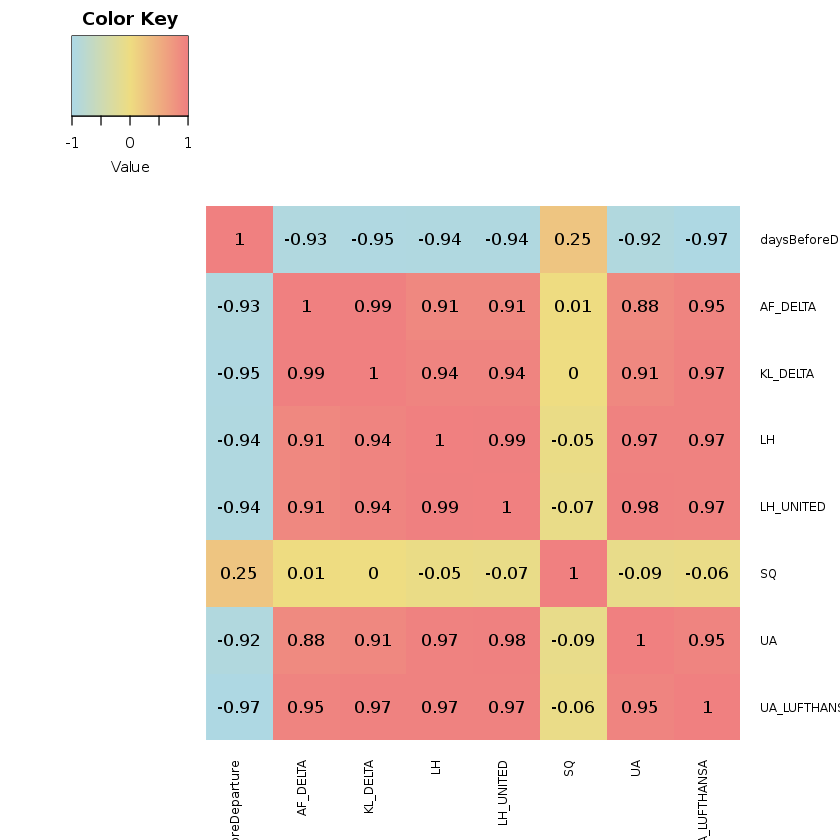

In [6]:
#qplot(x=Var1, y=Var2, data=melt(fare.correlation), fill=value, geom="tile")
#heatmap(fare.correlation, Rowv=NA, Colv=NA, col = heat.colors(512), scale="column", margins=c(1,5))
colfunc <- colorRampPalette(c("lightblue", "lightgoldenrod", "lightcoral"))
heatmap.2(fare.correlation, 
          col=colfunc(299), scale="none",
          cellnote = fare.correlation, notecol="black",
          key=TRUE, keysize=1.3,
          density.info="none", trace="none",
          symm = TRUE, dendrogram="none", Rowv = FALSE,
          cexRow=0.7,cexCol=0.7)
